In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import requests, gzip
import numpy as np
def get(url):
    return np.frombuffer(gzip.decompress(requests.get(url).content), dtype=np.uint8)

X_train = get("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = get("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = get("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = get("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

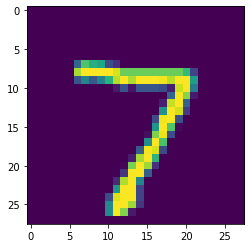

In [112]:
from matplotlib.pyplot import imshow
imshow(X_test[0])

In [116]:
import torch
torch.set_printoptions(sci_mode=False)
# Feature Scaling
X_train_scaled = torch.tensor([np.reshape(xi/256, (-1)) for xi in X_train], dtype=torch.float32)
X_test_scaled = torch.tensor([np.reshape(xi/256, (-1, 28*28)) for xi in X_test], dtype=torch.float32)

# One-Hot encoded targets
y_train_one_hot = [[1 if i == l else 0 for i in range(10)] for l in y_train]
y_test_one_hot = [[1 if i == l else 0 for i in range(10)] for l in y_test]

y_train_torch = torch.tensor(y_train.copy())
y_test_torch = torch.tensor(y_test.copy())
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train_ds = TensorDataset(X_train_scaled, y_train_torch)
test_ds = TensorDataset(X_test_scaled, y_test_torch)
BS = 250
train_dl = DataLoader(train_ds, BS, shuffle=True)
test_dl = DataLoader(test_ds)

In [117]:
import model
torch.manual_seed(0)
model = model.conNet()
x = X_test_scaled[0]
x = torch.tensor(x.reshape((-1, 28*28)), dtype=torch.float32)
model.forward(x)

/var/folders/c4/j059kg7n61q9x8b27zrclg8c0000gn/T/ipykernel_6515/733587254.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x.reshape((-1, 28*28)), dtype=torch.float32)


tensor([[-144.618682861328, -747.236938476562,    0.000000000000,
         -444.363891601562, -228.119018554688, -872.891601562500,
         -251.437133789062, -309.640045166016,  -35.315368652344,
         -211.119354248047]], grad_fn=<LogSoftmaxBackward0>)

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from tqdm import tqdm
N_EPOCH = 10
LR = 0.01
loss_hist = np.zeros(N_EPOCH)
accuracy_hist = np.zeros(N_EPOCH)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
for epoch in tqdm(range(N_EPOCH)):
    for x_batch, y_batch in train_dl:
        # print(pred[0], y_batch[0])
        # imshow((x_batch[0][0]*256).reshape(28,28))
        b_x = Variable(x_batch)
        b_y = Variable(y_batch)
        pred = model.forward(b_x)
        loss = loss_fn(pred, b_y)
        # clear gradients for this training step
        optimizer.zero_grad()
        # backprop, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()
        loss_hist[epoch] += loss.item()*y_batch.size()[0]
print(loss_hist)

100%|██████████| 100/100 [00:37<00:00,  2.72it/s]

[869545.67503929 223234.16230083 120460.91192961  73216.85762703
  49171.14201933  35051.9469725   27219.29812897  21570.49680874
  18697.5200531   15405.91172595  13639.67786543  11456.45928022
  10876.24799884  13190.46288583  13624.83875756  11813.52743474
   9394.10843842   9964.67342248   8880.16444091   9904.49378308
   9926.77162077   9922.12189313   7431.14337939   6834.59648746
   8412.1384047    9160.48626933  10343.24439413   6012.56859745
   7692.21056278   7229.23515255   6955.28604537   7639.73618446
   6277.81012646   4358.15245511   4392.37834332   3854.80780115
   4376.91953613   5365.53977159   6555.99800749   7434.10103722
   4879.81714098   5127.48424964   4785.60844239   4437.88289391
   5192.43436623   4737.84183436   3680.39627737   2970.80005089
   4491.67142926   4143.46698501   5660.47651014   4234.8181139
   3111.24601236   2723.94427306   3117.8987746    3198.49255734
   3522.147012     3632.1092686    4324.89973482   3497.27212846
   4260.21919888   3591.32

In [162]:
correct_clas_test = 0
misclassified = 0
for x, target in test_dl:
    b_x = Variable(x)[0]
    pred = model.forward(b_x)
    top_1 = torch.argmax(pred)
    if top_1 == target:
        correct_clas_test += 1
    else:
        misclassified += 1
print(correct_clas_test, misclassified)

9721 279


pred: 4, target: 4


/var/folders/c4/j059kg7n61q9x8b27zrclg8c0000gn/T/ipykernel_6515/2873144522.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x.reshape((-1, 28*28)), dtype=torch.float32)


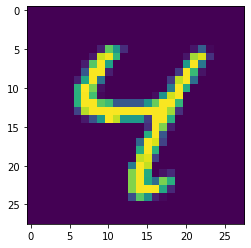

In [150]:
n = 6
x = X_test_scaled[n]
x = torch.tensor(x.reshape((-1, 28*28)), dtype=torch.float32)
o = model.forward(x)
print(f'pred: {torch.argmax(o)}, target: {y_test[n]}')
imshow(X_test[n])